# Overview

The goal of this notebook is to collect data from EIA of electricity accounts by state and sector to calculate:

$$ \text{kWh_percapita} = \frac{\text{kWh}}{\text{electric_accounts}}$$

Sectors include - Residential (RES), Commericial (COM), Transporation (TRA), Industrial (IND), and Other (OTH)

Still To Do:
* **Status - Complete**
* Check kWh per capita calculation for states AR, AK, and AZ.  It's odd that they all start with the letter A.
* Place plots into slide deck

Other notebooks to reference:
* [Electricity_Sales_EDA]("https://colab.research.google.com/drive/1LP_qEQlQGi64VO5tJs7_86WKwdNUIm8V#scrollTo=ifZsZJ-ECsKk")


# Look at EIA population - https://www.eia.gov/opendata/qb.php?category=40367&sdid=SEDS.TPOPP.AL.A

In [ ]:
import requests
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [ ]:
try:
    from google.colab import drive

    drive.mount('./drive/')

    %cd drive/My \ Drive/Data606_Energy

except:
    print("No Colab Environment")

Mounted at ./drive/
[Errno 2] No such file or directory: 'drive/My  Drive/Data606_Energy'
/content


In [ ]:
import sys
import pandas as pd
import glob
from tqdm.autonotebook import tqdm
sys.path.append("helpers/")

from energygrid import EGRID

from helper_functions import write_csv, combine_like_files
import json
import numpy as np

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [ ]:
energy_grid = EGRID()
energy_grid.get_states()

# Per Capita

## Census Data

In [ ]:
def clean_census(df):
    p_estimate = [col for col in df.columns if col.startswith("POPESTIMATE")]

    df = df.assign(state_population=df[p_estimate].values.tolist())

    df = df.assign(year=[list(range(2010,2022))] * len(df))

    df_population_recordwise = df.drop(columns=p_estimate).explode("state_population").explode("year").reset_index(drop=True)

    return df_population_recordwise


In [ ]:
with open("resources/us_state_abbreviation.json") as f:

    state_abbrv = json.load(f)

    df_state_abbrv = pd.DataFrame(state_abbrv.values(),index=state_abbrv.keys(),columns=["abbrv"]).reset_index().rename(columns={"index":"state"})

In [ ]:
df_population = (df_state_abbrv.merge(
                pd.read_csv("https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/state/totals/nst-est2020-alldata.csv"),
                how="right",left_on="state",right_on="NAME"
                )
                .drop(columns=["state"])
                )

In [ ]:
keep_cols = ["abbrv","NAME"] + [col for col in df_population.columns if col.startswith("POPESTIMATE")]

df_population_trim = df_population[keep_cols]

In [ ]:
df_population_trim

,abbrv,NAME,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020
0,NaN,United States,309327143,311583481,313877662,316059947,318386329,320738994,323071755,325122128,326838199,328329953,329484123
1,NaN,Northeast Region,55380764,55608318,55782661,55912775,56021339,56052790,56063777,56083383,56084543,56002934,55849869
2,NaN,Midwest Region,66975328,67164092,67348275,67576524,67765576,67885682,68018175,68160342,68263019,68340091,68316744
3,NaN,South Region,114869421,116019483,117264196,118397213,119666248,121049223,122419547,123611036,124649156,125686544,126662754
4,NaN,West Region,72101630,72791588,73482530,74173435,74933166,75751299,76570256,77267367,77841481,78300384,78654756
5,AL,Alabama,4785514,4799642,4816632,4831586,4843737,4854803,4866824,4877989,4891628,4907965,4921532
6,AK,Alaska,713982,722349,730810,737626,737075,738430,742575,740983,736624,733603,731158
7,AZ,Arizona,6407342,6473416,6556344,6634690,6732873,6832810,6944767,7048088,7164228,7291843,7421401
8,AR,Arkansas,2921998,2941038,2952876,2960459,2968759,2979732,2991815,3003855,3012161,3020985,3030522
9,CA,California,37319550,37636311,37944551,38253768,38586706,38904296,39149186,39337785,39437463,39437610,39368078


In [ ]:
p_estimate = [col for col in df_population_trim.columns if col.startswith("POPESTIMATE")]

population_trim_series = df_population_trim.assign(state_population=df_population_trim[p_estimate].values.tolist())

year_list = np.array([list(range(2010,2021))] * len(population_trim_series)).flatten().tolist()


In [ ]:
df_population_recordwise = population_trim_series.drop(columns=p_estimate)
df_population_recordwise = df_population_recordwise.explode("state_population")

df_population_recordwise["year"] = year_list

In [ ]:
df_population_recordwise.set_index(["NAME","year"])

abbrv state_population
NAME          year                       
United States 2010   NaN        309327143
              2011   NaN        311583481
              2012   NaN        313877662
              2013   NaN        316059947
              2014   NaN        318386329
...                  ...              ...
Puerto Rico   2016    PR          3406672
              2017    PR          3325284
              2018    PR          3193344
              2019    PR          3193553
              2020    PR          3159343

[627 rows x 2 columns]

In [ ]:
states = 57
years = 11

assert len(df_population_recordwise) == (states * years)

In [ ]:
df_population_recordwise.to_csv("data/percapita/census_2010_2021.csv",index=False)

# Start Here - Place them in Res, Com, Tra, Ind folders

In [ ]:
with open ("creds/eia_creds.json") as f:
    creds = json.load(f)
    key = creds.get("key")

[Number of Electricity Accounts]("https://www.eia.gov/opendata/qb.php?category=1718389")


RES- http://api.eia.gov/series/?api_key=YOUR_API_KEY_HERE&series_id=ELEC.CUSTOMERS.AL-RES.A
COM- http://api.eia.gov/series/?api_key=YOUR_API_KEY_HERE&series_id=ELEC.CUSTOMERS.AL-COM.A
ind- http://api.eia.gov/series/?api_key=YOUR_API_KEY_HERE&series_id=ELEC.CUSTOMERS.AL-IND.A
TRA- http://api.eia.gov/series/?api_key=YOUR_API_KEY_HERE&series_id=ELEC.CUSTOMERS.AZ-TRA.A

**Residential DATA**-**CUSTOMERS**


In [ ]:
sectors = ["ALL","RES","COM","IND","TRA","OTH"]
electric_account_kickout = set()

for sector in tqdm(sectors):
    print(sector)
    for index, state in enumerate(tqdm(energy_grid.states)):
        try:
            response = requests.get(f"http://api.eia.gov/series/?api_key={key}&series_id=ELEC.CUSTOMERS.{state}-{sector}.M").json()

            data_series = response.get("series")[0]

            df = pd.DataFrame(data_series)

            fn_json = f"data/percapita/electric_accounts/json/{sector}/{state}_electric_accounts.json"

            df["sector"] = sector

            df.to_json(fn_json)
        except TypeError:
            electric_account_kickout.add((sector,state))

  0%|          | 0/6 [00:00<?, ?it/s]

ALL


  0%|          | 0/51 [00:00<?, ?it/s]

RES


  0%|          | 0/51 [00:00<?, ?it/s]

COM


  0%|          | 0/51 [00:00<?, ?it/s]

IND


  0%|          | 0/51 [00:00<?, ?it/s]

TRA


  0%|          | 0/51 [00:00<?, ?it/s]

OTH


  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
#index and plants combinations not found
write_csv("data/percapita/electric_accounts/kickouts.csv",["sector","state"],electric_account_kickout)

File written to data/percapita/electric_accounts/kickouts.csv


In [ ]:
pd.read_csv("data/percapita/electric_accounts/kickouts.csv").groupby(["sector","state"]).count()

Empty DataFrame
Columns: []
Index: [(OTH, AK), (OTH, AL), (OTH, AR), (OTH, AZ), (OTH, CA), (OTH, CO), (OTH, CT), (OTH, DC), (OTH, DE), (OTH, FL), (OTH, GA), (OTH, HI), (OTH, IA), (OTH, ID), (OTH, IL), (OTH, IN), (OTH, KS), (OTH, KY), (OTH, LA), (OTH, MA), (OTH, MD), (OTH, ME), (OTH, MI), (OTH, MN), (OTH, MO), (OTH, MS), (OTH, MT), (OTH, NC), (OTH, ND), (OTH, NE), (OTH, NH), (OTH, NJ), (OTH, NM), (OTH, NV), (OTH, NY), (OTH, OH), (OTH, OK), (OTH, OR), (OTH, PA), (OTH, RI), (OTH, SC), (OTH, SD), (OTH, TN), (OTH, TX), (OTH, UT), (OTH, VA), (OTH, VT), (OTH, WA), (OTH, WI), (OTH, WV), (OTH, WY), (TRA, AK), (TRA, AL), (TRA, DE), (TRA, HI), (TRA, IA), (TRA, ID), (TRA, KS), (TRA, KY), (TRA, ME), (TRA, MS), (TRA, MT), (TRA, ND), (TRA, NE), (TRA, NH), (TRA, NM), (TRA, OK), (TRA, SC), (TRA, SD), (TRA, VT), (TRA, WY)]

[71 rows x 0 columns]

In [ ]:
df = combine_like_files("data/percapita/electric_accounts/json/*/*",pd.read_json)

In [ ]:
df.sample(10)

,series_id,name,units,f,description,copyright,source,iso3166,geography,start,end,updated,data,sector
13531,ELEC.CUSTOMERS.NM-COM.M,Number of customer accounts : New Mexico : com...,number of customers,M,Electricity sold to commercial customers; Elec...,None,"EIA, U.S. Energy Information Administration",USA-NM,USA-NM,200801,202107,2021-09-23T14:54:35-0400,"[202105, 144630]",COM
28614,ELEC.CUSTOMERS.PA-TRA.M,Number of customer accounts : Pennsylvania : t...,number of customers,M,Electricity sold to transportation customers; ...,None,"EIA, U.S. Energy Information Administration",USA-PA,USA-PA,200801,202107,2021-09-23T14:54:35-0400,"[201402, 5]",TRA
11783,ELEC.CUSTOMERS.MI-COM.M,Number of customer accounts : Michigan : comme...,number of customers,M,Electricity sold to commercial customers; Elec...,None,"EIA, U.S. Energy Information Administration",USA-MI,USA-MI,200801,202107,2021-09-23T14:54:35-0400,"[201708, 543406]",COM
6624,ELEC.CUSTOMERS.TN-RES.M,Number of customer accounts : Tennessee : resi...,number of customers,M,Electricity sold to residential customers; Ele...,None,"EIA, U.S. Energy Information Administration",USA-TN,USA-TN,200801,202107,2021-09-23T14:54:35-0400,"[201211, 2722885]",RES
27396,ELEC.CUSTOMERS.MO-TRA.M,Number of customer accounts : Missouri : trans...,number of customers,M,Electricity sold to transportation customers; ...,None,"EIA, U.S. Energy Information Administration",USA-MO,USA-MO,200801,202107,2021-09-23T14:54:35-0400,"[202007, 2]",TRA
12696,ELEC.CUSTOMERS.MS-COM.M,Number of customer accounts : Mississippi : co...,number of customers,M,Electricity sold to commercial customers; Elec...,None,"EIA, U.S. Energy Information Administration",USA-MS,USA-MS,200801,202107,2021-09-23T14:54:35-0400,"[200906, 224178]",COM
5564,ELEC.CUSTOMERS.ND-RES.M,Number of customer accounts : North Dakota : r...,number of customers,M,Electricity sold to residential customers; Ele...,None,"EIA, U.S. Energy Information Administration",USA-ND,USA-ND,200801,202107,2021-09-23T14:54:35-0400,"[201909, 386279]",RES
28989,ELEC.CUSTOMERS.TX-TRA.M,Number of customer accounts : Texas : transpor...,number of customers,M,Electricity sold to transportation customers; ...,None,"EIA, U.S. Energy Information Administration",USA-TX,USA-TX,200801,202107,2021-09-23T14:54:35-0400,"[201001, 3]",TRA
28643,ELEC.CUSTOMERS.PA-TRA.M,Number of customer accounts : Pennsylvania : t...,number of customers,M,Electricity sold to transportation customers; ...,None,"EIA, U.S. Energy Information Administration",USA-PA,USA-PA,200801,202107,2021-09-23T14:54:35-0400,"[201109, 15]",TRA
34473,ELEC.CUSTOMERS.MT-ALL.M,Number of customer accounts : Montana : all se...,number of customers,M,All end-use sectors that consume electricity; ...,None,"EIA, U.S. Energy Information Administration",USA-MT,USA-MT,200801,202107,2021-09-23T14:54:35-0400,"[201411, 599979]",ALL


# Validation
* To check whether each state has the same amount of records per sector

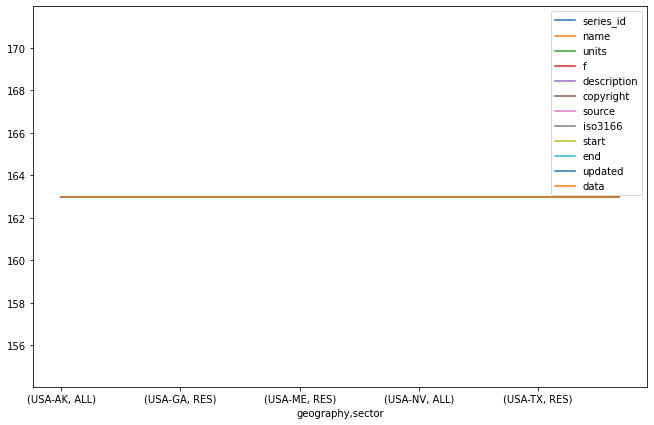

In [ ]:
_ = df.groupby(["geography","sector"]).count().plot(figsize=(11,7))